In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
import xgboost as xgb

df = pd.read_csv("C:/Users/Korisnik/py/manufacturing/data/processed/logs_all_machineSs_features.csv")

### binary classification

- predviđam da li će naredni ciklus imati downtime

In [2]:
# Label: downtime_flag u sljedecem ciklusu
df['downtime_next'] = df['downtime_flag'].shift(-1)
df = df.dropna(subset=['downtime_next'])  # ukloni poslednji red koji nema "next"

In [3]:
df['operator_encoded'] = df['operator'].astype('category').cat.codes
df['maintenance_type_encoded'] = df['maintenance_type'].astype('category').cat.codes

# Features samo numeričke
features = [c for c in df.columns if c not in ['timestamp','cycle_id','production_order_id',
                                               'downtime_next','operator','maintenance_type']]
X = df[features]
y = df['downtime_next']

# XGBoost podržava kategorije samo ako enable_categorical=True
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# broj negativnih i pozitivnih primjera
neg, pos = np.bincount(y_train.astype(int))
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight = neg / pos   # za rare events
)

model.fit(X_train, y_train)

#evaluacija
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

roc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)

print(f"ROC-AUC: {roc:.3f}")
print(f"F1-score: {f1:.3f}")

c:\Users\Korisnik\py\manufacturing\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:52:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ROC-AUC: 0.496
F1-score: 0.043


### Rezultati

ROC-AUC oko 0.5 - model nasumican, trenutna obiljezja ne signaliziraju downtime pogodno
(Sa 3-4% downtime dogadjaja, signal je slab)

F1 0.04 - model skoro sve predvidja kao 0- RARE EVENT PROBLEM


Pokusacu:
- veci rolling window - 20 ciklusa;
- lag razlike i trendovi, za cycle_time i senzore

- scale_pos_weight ne pomaze:
- pokusati SMOTE/RandomOverSampler ili undersampling negativnih uzoraka


c:\Users\Korisnik\py\manufacturing\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:59:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ROC-AUC: 0.841
F1-score: 0.635


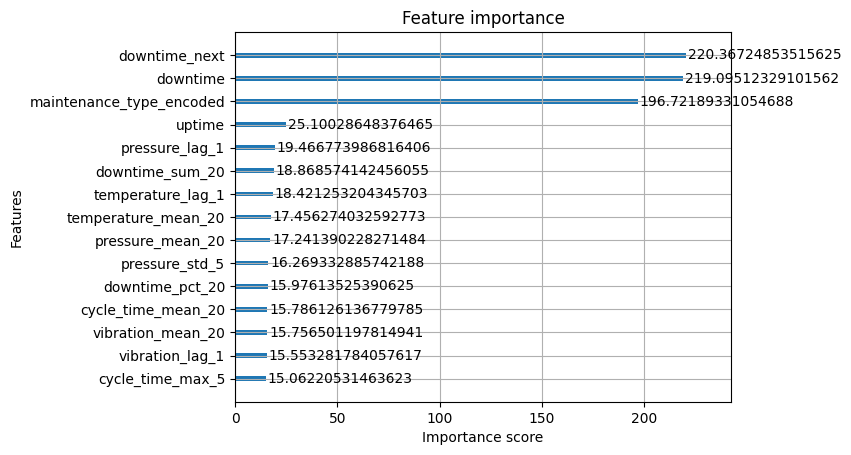

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
import matplotlib.pyplot as plt

# -----------------------------
# Windowed target (downtime u narednih 5 ciklusa)
# -----------------------------
window = 5
df['downtime_next_5'] = df['downtime_flag'].rolling(window, min_periods=1).max().shift(-window+1)
df = df.dropna(subset=['downtime_next_5'])

# -----------------------------
# Enhanced rolling / trend features
# -----------------------------
rolling_window = 20

# Cycle time rolling
df['cycle_time_mean_20'] = df['cycle_time'].rolling(rolling_window, min_periods=1).mean()
df['cycle_time_std_20'] = df['cycle_time'].rolling(rolling_window, min_periods=1).std().fillna(0)
df['cycle_time_diff_1'] = df['cycle_time'].diff(1).fillna(0)
df['cycle_time_trend_20'] = df['cycle_time_diff_1'].rolling(rolling_window, min_periods=1).mean()

# Sensor rolling
sensors = ['temperature','vibration','pressure']
for s in sensors:
    df[f'{s}_mean_20'] = df[s].rolling(rolling_window, min_periods=1).mean()
    df[f'{s}_std_20'] = df[s].rolling(rolling_window, min_periods=1).std().fillna(0)
    df[f'{s}_diff_1'] = df[s].diff(1).fillna(0)
    df[f'{s}_trend_20'] = df[f'{s}_diff_1'].rolling(rolling_window, min_periods=1).mean()

# Lag features
df['cycle_time_lag_1'] = df['cycle_time'].shift(1)
for s in sensors:
    df[f'{s}_lag_1'] = df[s].shift(1)

# -----------------------------
# Categorical encoding
# -----------------------------
df['operator_encoded'] = df['operator'].astype('category').cat.codes
df['maintenance_type_encoded'] = df['maintenance_type'].fillna('none').astype('category').cat.codes

# -----------------------------
# Features / target
# -----------------------------
features = [c for c in df.columns if c not in ['timestamp','cycle_id','production_order_id',
                                               'downtime_flag','downtime_next_5','operator','maintenance_type']]
X = df[features]
y = df['downtime_next_5']

# -----------------------------
# Train/test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# Oversampling minority class
# -----------------------------
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# -----------------------------
# XGBoost training
# -----------------------------
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train_res, y_train_res)

# -----------------------------
# Evaluation
# -----------------------------
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

roc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)

print(f"ROC-AUC: {roc:.3f}")
print(f"F1-score: {f1:.3f}")

# -----------------------------
# Feature importance
# -----------------------------
xgb.plot_importance(model, max_num_features=15, importance_type='gain')
plt.show()

### Rezultati

Feature engineering je znatno uticao na rezultat (veci rolling window, lag/trend/diff features). RandomOverSampler je omogucio da model uci i za rijetke dogadjaje.

In [10]:
import joblib

joblib.dump(model, "C:/Users/Korisnik/py/manufacturing/models/xgb_downtime_predictor.pkl")

['C:/Users/Korisnik/py/manufacturing/models/xgb_downtime_predictor.pkl']

In [11]:
df.to_csv("C:/Users/Korisnik/py/manufacturing/data/processed/logs_machine1_features_windowed.csv", index=False)

### Kreirati predikcije po ciklusima

(za integraciju u Tecnomatix simulaciju)

In [ ]:
X_all = df[features]
df['downtime_risk'] = model.predict_proba(X_all)[:,1]
df[['timestamp','machine_id','cycle_id','downtime_risk']].head()

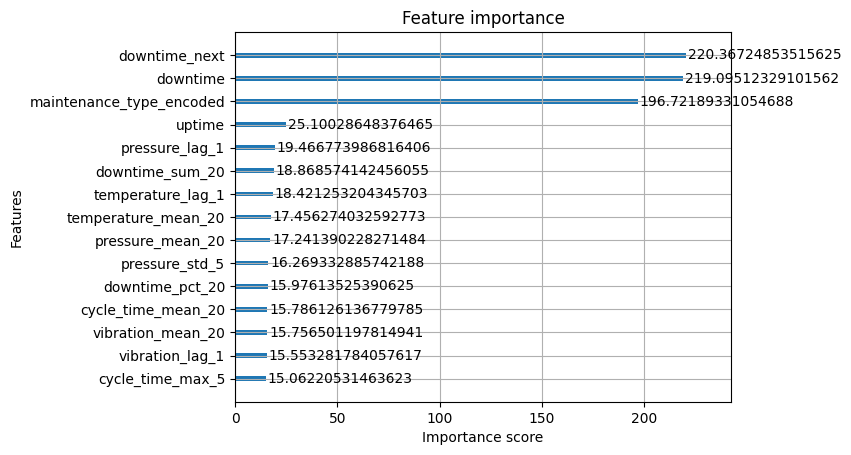

In [ ]:
xgb.plot_importance(model, max_num_features=15, importance_type='gain')
plt.show()